# TRAINING STAGES :
## 1. Self-supervised pretraining with SimCLR
## 2. Training of binarized prototypes based classifier with procedural adversarial noise augmentation
## 3. Information-extreme optimization of hypersherical decision doundaries for each class

# SELF-SUPERVISED PRETRAINING

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!mkdir train
!mkdir train/unlabeled
!cp /content/gdrive/MyDrive/Pipe_Hack_Data/train00.zip train00.zip 
!unzip /content/train00.zip -d /content/train/unlabeled/

Показано результат, скорочений до останніх рядків (5000).
  inflating: /content/train/unlabeled/00035501.png  
  inflating: /content/train/unlabeled/00035502.png  
  inflating: /content/train/unlabeled/00035503.png  
  inflating: /content/train/unlabeled/00035504.png  
  inflating: /content/train/unlabeled/00035505.png  
  inflating: /content/train/unlabeled/00035506.png  
  inflating: /content/train/unlabeled/00035507.png  
  inflating: /content/train/unlabeled/00035508.png  
  inflating: /content/train/unlabeled/00035509.png  
  inflating: /content/train/unlabeled/00035510.png  
  inflating: /content/train/unlabeled/00035511.png  
  inflating: /content/train/unlabeled/00035512.png  
  inflating: /content/train/unlabeled/00035513.png  
  inflating: /content/train/unlabeled/00035514.png  
  inflating: /content/train/unlabeled/00035515.png  
  inflating: /content/train/unlabeled/00035516.png  
  inflating: /content/train/unlabeled/00035517.png  
  inflating: /content/train/unlabeled/000

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_datasets as tfds
import os

## Hyperparameters

In [4]:
# Dataset hyperparameters
AUTO = tf.data.AUTOTUNE
SEED = 26
# path to input dir = INPUT_DIR/train/unlabeled
INPUT_DIR = "/content" #"F:/PIPE_DATASET"  #"SORTED_CONTEXT" 
image_size = 192
image_channels = 3
#print("unlabeled_dataset_size = ", unlabeled_dataset_size, " image_size = ", image_size)

# Algorithm hyperparameters
num_epochs = 10
batch_size = 64  # Corresponds to x steps per epoch
width = 64
temperature = 0.11

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}

## Dataset

During training we will simultaneously load a large batch of unlabeled images along with a
smaller batch of labeled images.

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=7),
    }),
    total_num_examples=33139,
    splits={
        '.config': 0,
        'gdrive': 0,
        'train': 33139,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



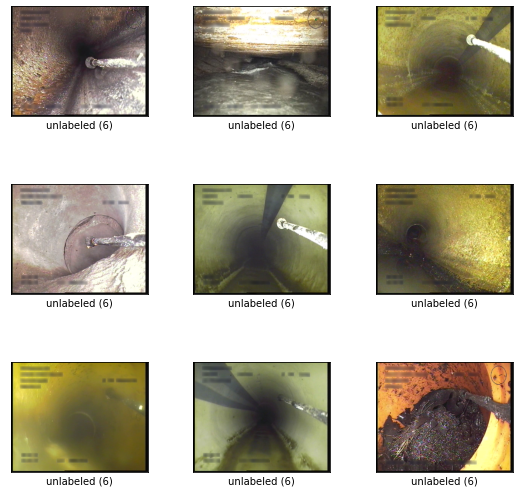

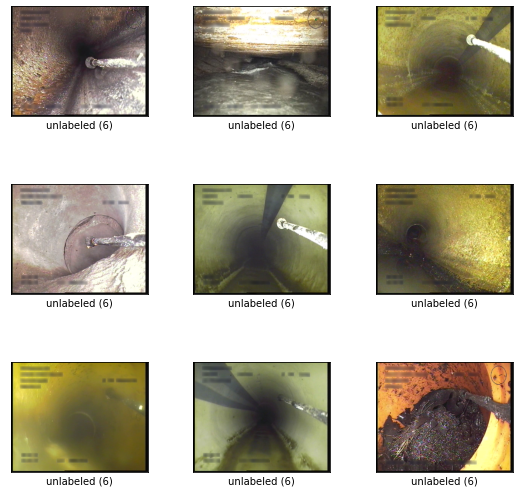

In [5]:
builder = tfds.ImageFolder(INPUT_DIR+"/")
print(builder.info)  

unlabeled_train_dataset = builder.as_dataset(shuffle_files=True, as_supervised=True, split="train")

tfds.show_examples(unlabeled_train_dataset, builder.info)

In [6]:
def resize(img, label):
    return tf.image.resize(img, [image_size, image_size])

unlabeled_train_dataset = (
    unlabeled_train_dataset.shuffle(1024, seed=SEED)
    .map(resize, num_parallel_calls=AUTO)
    .batch(batch_size)
    .prefetch(AUTO)
)

## Image augmentations

The two most important image augmentations for contrastive learning are the
following:

- Cropping: forces the model to encode different parts of the same image
similarly, we implement it with the
[RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_translation/)
and
[RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_zoom/)
layers
- Color jitter: prevents a trivial color histogram-based solution to the task by
distorting color histograms. A principled way to implement that is by affine
transformations in color space.

In this example we use random horizontal flips as well. Stronger augmentations
are applied for contrastive learning, along with weaker ones for supervised
classification to avoid overfitting on the few labeled examples.

We implement random color jitter as a custom preprocessing layer. Using
preprocessing layers for data augmentation has the following two advantages:

- The data augmentation will run on GPU in batches, so the training will not be
bottlenecked by the data pipeline in environments with constrained CPU
resources (such as a Colab Notebook, or a personal machine)
- Deployment is easier as the data preprocessing pipeline is encapsulated in the
model, and does not have to be reimplemented when deploying it

In [7]:
# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images

# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            preprocessing.Rescaling(1./127.5, offset=-1.0),   #1 / 255),
            #tf.keras.layers.Rescaling(1./127.5, offset=-1.0),
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            preprocessing.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )

## Encoder architecture

In [8]:
#**************************************************************************
#************************  base_feature_extractor.py  *********************
#**************************************************************************

# Define the encoder architecture
def get_encoder():
    extractor = tf.keras.applications.MobileNet(           
            input_shape=(image_size, image_size, 3),
            alpha=0.25, 
            include_top=False, 
            weights='imagenet' )
    inputs = extractor.output
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    outputs = tf.keras.layers.Dense(width, activation="relu", use_bias=False)(x)
    return tf.keras.Model(extractor.input, outputs, name="encoder") 

## Self-supervised model for contrastive pretraining

We pretrain an encoder on unlabeled images with a contrastive loss.
A nonlinear projection head is attached to the top of the encoder, as it
improves the quality of representations of the encoder.

We use the InfoNCE/NT-Xent/N-pairs loss, which can be interpreted in the
following way:

1. We treat each image in the batch as if it had its own class.
2. Then, we have two examples (a pair of augmented views) for each "class".
3. Each view's representation is compared to every possible pair's one (for both
  augmented versions).
4. We use the temperature-scaled cosine similarity of compared representations as
  logits.
5. Finally, we use categorical cross-entropy as the "classification" loss

The following two metrics are used for monitoring the pretraining performance:

- [Contrastive accuracy (SimCLR Table 5)](https://arxiv.org/abs/2002.05709):
Self-supervised metric, the ratio of cases in which the representation of an
image is more similar to its differently augmented version's one, than to the
representation of any other image in the current batch. Self-supervised
metrics can be used for hyperparameter tuning even in the case when there are
no labeled examples.
- [Linear probing accuracy](https://arxiv.org/abs/1603.08511): Linear probing is
a popular metric to evaluate self-supervised classifiers. It is computed as
the accuracy of a logistic regression classifier trained on top of the
encoder's features. In our case, this is done by training a single dense layer
on top of the frozen encoder. Note that contrary to traditional approach where
the classifier is trained after the pretraining phase, in this example we
train it during pretraining. This might slightly decrease its accuracy, but
that way we can monitor its value during training, which helps with
experimentation and debugging.

Another widely used supervised metric is the
[KNN accuracy](https://arxiv.org/abs/1805.01978), which is the accuracy of a KNN
classifier trained on top of the encoder's features, which is not implemented in
this example.

In [9]:
#**************************************************************************
#************************  self_supervised_trainer.py  ********************
#**************************************************************************

# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        self.encoder.summary()
        self.projection_head.summary()

    def compile(self, contrastive_optimizer, **kwargs): #, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )
        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )
        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, unlabeled_images):
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(unlabeled_images)
        augmented_images_2 = self.contrastive_augmenter(unlabeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)       
        return {m.name: m.result() for m in self.metrics}

In [10]:
# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam()
)

2121728/2108140 [==============================] - 0s 0us/step
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 8)         216       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 96, 96, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 96, 96, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 96, 96, 8)        72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 96, 96, 8)        32     

In [11]:
pretraining_history = pretraining_model.fit(
    unlabeled_train_dataset, epochs=num_epochs
)

Epoch 1/10
518/518 [==============================] - 366s 659ms/step - c_loss: 0.3697 - c_acc: 1.0000
Epoch 2/10
518/518 [==============================] - 353s 663ms/step - c_loss: 0.0767 - c_acc: 1.0000
Epoch 3/10
518/518 [==============================] - 347s 653ms/step - c_loss: 0.0710 - c_acc: 1.0000
Epoch 4/10
518/518 [==============================] - 353s 663ms/step - c_loss: 0.0469 - c_acc: 1.0000
Epoch 5/10
518/518 [==============================] - 347s 653ms/step - c_loss: 0.0408 - c_acc: 1.0000
Epoch 6/10
518/518 [==============================] - 359s 676ms/step - c_loss: 0.0373 - c_acc: 1.0000
Epoch 7/10
518/518 [==============================] - 355s 667ms/step - c_loss: 0.0401 - c_acc: 1.0000
Epoch 8/10
518/518 [==============================] - 352s 661ms/step - c_loss: 0.0520 - c_acc: 1.0000
Epoch 9/10
518/518 [==============================] - 352s 661ms/step - c_loss: 0.0385 - c_acc: 1.0000
Epoch 10/10
518/518 [==============================] - 349s 656ms/step - 

In [28]:
pretraining_model.encoder.save_weights("gdrive/MyDrive/extractor_model.hdf5")

# TRAINING OF PROTOTYPE BASED CLASSIFIER

In [12]:
initial_learning_rate = 1e-3
batch_size = 128
epochs = 50
weight_decay = 0.0005
output_dim = 64
class_num = 12 
# class_num = len(os.listdir("/content/context_dataset_originals_v1.0/context_dataset_originals"))
# image_size = 192

## load labeled data

In [13]:
!cp '/content/gdrive/MyDrive/context_dataset_originals_v1.0.zip' '/content/context_dataset_originals_v1.0.zip'
!unzip  '/content/context_dataset_originals_v1.0.zip' -d 'context_dataset_originals_v1.0'

Показано результат, скорочений до останніх рядків (5000).
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S033-066_S033-055_20200903_U_TBC_45.5.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S033-602_S033-044_20200806_U_TFC_164.6.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S034-070_S034-069_20200803_D_TFC_148.6.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S034-253_S034-255_20200730_D_TFC_55.7.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S035-280_S035-281_20170811_U_TFC_131.1.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S035-321_S035-322_20170811_U_TFC_49.1.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S035-322_S035-319_20200811_D_TFC_95.3.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_orig

In [14]:
!pip install split-folders

In [15]:
import splitfolders

splitfolders.ratio('context_dataset_originals_v1.0/context_dataset_originals/', 
                    output="output", ratio=(.8, 0.1,0.1)) 

Copying files: 72004 files [02:06, 571.01 files/s]


## data augmentation operations

In [16]:
!pip install noise

     |████████████████████████████████| 132 kB 14.6 MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp37-cp37m-linux_x86_64.whl size=64366 sha256=9ce31e81636e1e747459dcecb06b60158ac8f17f6854a4211644efa7613255f1
  Stored in directory: /root/.cache/pip/wheels/50/4f/1d/3e94460751c993553ba1a52b8e571ba6510701b4d0a68ffeea
Successfully built noise


In [17]:
import cv2
import random
import numpy as np
from noise import pnoise2

def normalize_var(orig):
    size = orig.shape[0]
    # Spectral variance
    mean = np.mean(orig)
    spec_var = np.fft.fft2(np.square(orig -  mean))
    # Normalization
    imC = np.sqrt(abs(np.real(np.fft.ifft2(spec_var))))
    imC /= np.max(imC)
    minC = 0.001
    imK =  (minC + 1) / (minC + imC)
    img = mean + (orig -  mean) * imK    
    return normalize(img)

# Normalize vector
def normalize(vec):
    vmax = np.amax(vec)
    vmin  = np.amin(vec)
    return (vec - vmin) / (vmax - vmin)

# Valid positions for Gabor noise
def valid_position(size, x, y):
    if x < 0 or x >= size: return False
    if y < 0 or y >= size: return False
    return True

### Procedural Noise ###
# Note: Do not take these as optimized implementations.
'''
Gabor kernel
sigma       variance of gaussian envelope
theta         orientation
lambd       sinusoid wavelength, bandwidth
xy_ratio    value of x/y
psi            phase shift of cosine in kernel
sides        number of directions
'''
def gaborK(ksize, sigma, theta, lambd, xy_ratio, sides):
    gabor_kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
    for i in range(1, sides):
        gabor_kern += cv2.getGaborKernel((ksize, ksize), sigma, theta + np.pi * i / sides, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
    return gabor_kern

'''
Gabor noise
- randomly distributed kernels
- anisotropic when sides = 1, pseudo-isotropic for larger "sides"
'''
def gaborN_rand(size, grid, num_kern, ksize, sigma, theta, lambd, xy_ratio = 1, sides = 1, seed = 0):
    np.random.seed(seed)
    # Gabor kernel
    if sides != 1: gabor_kern = gaborK(ksize, sigma, theta, lambd, xy_ratio, sides)
    else: gabor_kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
    # Sparse convolution noise
    sp_conv = np.zeros([size, size])
    dim = int(size / 2 // grid)
    noise = []
    for i in range(-dim, dim + 1):
        for j in range(-dim, dim + 1):
            x = i * grid + size / 2 - grid / 2
            y = j * grid + size / 2 - grid / 2
            for _ in range(num_kern):
                dx = np.random.randint(0, grid)
                dy = np.random.randint(0, grid)
                while not valid_position(size, x + dx, y + dy):
                    dx = np.random.randint(0, grid)
                    dy = np.random.randint(0, grid)
                weight = np.random.random() * 2 - 1
                sp_conv[int(x + dx)][int(y + dy)] = weight
    
    sp_conv = cv2.filter2D(sp_conv, -1, gabor_kern)
    return normalize(sp_conv)

'''
Gabor noise
- controlled, uniformly distributed kernels
grid        ideally is odd and a factor of size
thetas    orientation of kernels, has length (size / grid)^2
'''
def gaborN_uni(size, grid, ksize, sigma, lambd, xy_ratio, thetas):
    sp_conv = np.zeros([size, size])
    temp_conv = np.zeros([size, size])
    dim = int(size / 2 // grid)
    
    for i in range(-dim, dim + 1):
        for j in range(-dim, dim + 1):
            x = i * grid + size // 2
            y = j * grid + size // 2
            temp_conv[x][y] = 1
            theta = thetas[(i + dim) * dim * 2 + (j + dim)]
            
            # Gabor kernel
            gabor_kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
            sp_conv += cv2.filter2D(temp_conv, -1, gabor_kern)
            temp_conv[x][y] = 0
    
    return normalize(sp_conv)

'''
Perlin noise
- with sine color map
'''
def perlin(size, period, octave, freq_sine, lacunarity = 2):
    # Perlin noise
    noise = np.empty((size, size), dtype = np.float32)
    for x in range(size):
        for y in range(size):
            noise[x][y] = pnoise2(x / period, y / period, octaves = octave, lacunarity = lacunarity)  
    # Sine function color map
    noise = normalize(noise)
    noise = np.sin(noise * freq_sine * np.pi)
    return normalize(noise)

'''
Color noise
noise           has dimension 2 or 3, pixel range [0, 255]
color            is [a, b, c] where a, b, c are from {-1, 0, 1}
'''
def colorize(noise, color = [1, 1, 1]):
    if noise.ndim == 2: # expand to include color channels
        noise = np.expand_dims(noise, 2)
    return (noise - 0.5) * color * 2 # output pixel range [-1, 1]

'''
Perturb image and clip to maximum perturbation norm
img              image with pixel range [0, 1]
noise           noise with pixel range [-1, 1]
norm           L-infinity norm constraint
'''
def perturb(img, noise, norm):
    noise = np.sign((noise - 0.5) * 2) * norm
    noise = np.clip(noise, np.maximum(-img, -norm), np.minimum(255 - img, norm))
    return (img + noise)

# grid = default_value = 23, 14, ...  - Size of the grid the image is divided into.
# max_norm = [0, 64], default_value = 12 - L-infinity norm constraint 
# num_kern = [1, 200], defaut_value = 23   - Number of kernels added to each grid.
# ksize    = [1, 40], default_value = 23   - Size of each kernel. When kernel size is reduced to one, the resulting image will just be the sparse white noise.
# sigma    = [2, 20], default_value = 8 - Variance of the Gaussian.
# theta    = [0, np.pi], default_value = np.pi / 4 - Orientation or angle of the kernel.
# lambd    = [0.25, 20], default_value = 10 - Wavelength of the sinusoidal factor in the Harmonic kernel. In the spectral domain, this changes the distance between the lobes.
# color    = 'Black-White', 'Red-Cyan', 'Green-Magenta', 'Blue-Yellow'
def gabor_noise(image, max_norm=30, num_kern=23, ksize=23, sigma=8, 
                theta=np.pi / 4, lambd=10, grid=23, color = 'Black-White'): 
    if color == 'Black-White': coloring = [1, 1, 1]
    if color == 'Red-Cyan': coloring = [1, -1, -1]
    if color == 'Green-Magenta': coloring = [-1, 1, -1]
    if color == 'Blue-Yellow': coloring = [-1, -1, 1]
    # Noise pattern    
    noise = gaborN_rand(size = image_size, grid = grid, num_kern = num_kern, ksize = ksize, sigma = sigma, theta = theta, lambd = lambd)
    noise = normalize_var(noise)
    noise = colorize(noise, coloring)    
    # Altered image
    payload = perturb(img = image.astype(np.float), noise = noise, norm = max_norm)
    return payload.astype(np.uint8) #.astype(np.float).reshape((1, image_size, image_size, 3))
   
# max_norm   = [0, 64], default_value = 12 - L-infinity norm constraint
# period     = [2, 180], default_value = 60
# freq_sine  = [0,60] default_value = 36
# octave     = [1, 2, 3, 4]
def perlin_noise(image, max_norm=12, period=60, freq_sine=36, octave=3):
    # Noise pattern   
    noise = perlin(size = image_size, period = period, octave = octave, freq_sine = freq_sine)
    noise = colorize(noise)  # noise with pixel range [-1, 1]
    # Altered image
    payload = perturb(img = image.astype(np.float), norm = max_norm, noise = noise)
    return payload.astype(np.uint8) #.astype(np.float).reshape((1, image_size, image_size, 3))

def adversarial_augmentation(image):
    noise_type_flag = random.choice([True, False])
    if noise_type_flag :
        grid = random.randint(14, 24)       # default_value = 23, 14, 
        max_norm = random.randint(0, 64)    # default_value = 12 
        num_kern = random.randint(5, 150)   # defaut_value = 23  
        ksize    = random.randint(3, 40)    # default_value = 23   
        sigma    = random.randint(2, 20)    # default_value = 8 
        theta    = random.uniform(0, np.pi) # default_value = np.pi / 4 - Orientation or angle of the kernel.
        lambd    = random.uniform(0.25, 20) # default_value = 10 
        color    = random.choice(['Black-White', 'Red-Cyan', 'Green-Magenta', 'Blue-Yellow'])
        # generate perturbed image
        noised_img = gabor_noise(image, max_norm=30, num_kern=23, 
                                 ksize=23, sigma=8, theta=np.pi / 4, 
                                 lambd=10, grid=23, color = 'Black-White')
    else :
        max_norm_v   = random.randint(0, 64)  # default_value = 12 
        period_v     = random.randint(2, 180) # default_value = 60
        freq_sine_v  = random.randint(0, 60)  # default_value = 36
        octave_v     = random.randint(1, 4)   #
        # generate perturbed image
        noised_img = perlin_noise(image, max_norm=max_norm_v, period=period_v, 
                                  freq_sine=freq_sine_v, octave=octave_v)
    return noised_img

In [18]:
import cv2
import numpy as np
from noise import pnoise2
import random

def adversarial_preprocessor(image):
    noised_img = adversarial_augmentation(image)
    return tf.keras.applications.mobilenet.preprocess_input(noised_img)

In [19]:
from datetime import datetime
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight

#****************************************                       

dg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=adversarial_preprocessor, #tf.keras.applications.mobilenet.preprocess_input,
)

train_ds = dg.flow_from_directory(
    directory='/content/output/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode= 'categorical',
    seed=42
)

test_ds = dg.flow_from_directory(
    directory='/content/output/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode= 'categorical',
    seed=42
)

#****************************************

dg2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=None, 
)

train_ds2 = dg.flow_from_directory(
    directory='/content/output/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

test_ds2 = dg.flow_from_directory(
    directory='/content/output/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

def convert_generator_to_input_2(image_data_gen):
    for image, label in image_data_gen:
        yield [label, np.array([0])]

train_dds = convert_generator_to_input_2(train_ds2)
test_dds = convert_generator_to_input_2(test_ds2)

#****************************************

early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0,
                                                  verbose=1, mode='auto', cooldown=0, min_lr=1e-15)
cbs = [early_stop, reduce_lr]

Found 57600 images belonging to 12 classes.
Found 7195 images belonging to 12 classes.
Found 57600 images belonging to 12 classes.
Found 7195 images belonging to 12 classes.


## feature extractor tuning and train prototypes

In [20]:
#**************************************************************************
#************************  prototype_layer.py  ****************************
#**************************************************************************

### special layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class BinarizedPrototypeLoss(tf.keras.layers.Layer):
  
    def __init__(self, num_classes=1, dim_hidden=1, lambda_c=1.0, **kwargs):
        super().__init__(**kwargs)
        self.dim_hidden  = dim_hidden
        self.num_classes = num_classes
        self.lambda_c    = tf.constant(lambda_c, dtype=tf.float32)       
        self.epsilon     = tf.constant(1e-6, dtype=tf.float32)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, self.dim_hidden),
                                       initializer=tf.keras.initializers.RandomUniform(minval=0., maxval=1.),
                                       trainable=True)   
        super().build(input_shape)

    def call(self, inputs, mask=None):
        embedding, labels   = inputs[0], inputs[1]
        labels_int          = tf.math.argmax(labels, axis=1) 
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_centers    = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_centers    = tf.math.reduce_sum( distance_centers, axis=2 )
        # Contrastive Center 
        distances_intra     = tf.gather( distance_centers, indices=tf.expand_dims(labels_int, axis=1), batch_dims=1 )
        distances_sum       = tf.math.reduce_sum( distance_centers, axis=1 )
        distances_sum       = tf.expand_dims( distances_sum, axis=0 )
        distances_sum       = tf.transpose( distances_sum )
        distance_inter      = distances_sum - distances_intra
        loss1               = distances_intra/( distance_inter+self.epsilon)#self.lambda_c ) 
        # Cross Entropy over distance distribution
        loss2               = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(labels, -1.0*distance_centers)
        loss2               = tf.expand_dims(loss2, axis=0)  
        loss2               = tf.transpose(loss2)
        # Regularization for output discritization
        # *********** for features discritization *******************    
        e                   = tf.ones([batch_size, self.dim_hidden] )
        dif                 = tf.linalg.matmul(embedding, e-embedding, transpose_b=True)
        loss3               = tf.linalg.tensor_diag_part(dif)
        loss3               = tf.expand_dims(loss3, axis=0)  
        loss3               = tf.transpose(loss3)
        # *********** for prototypes discritization *******************    
        ec                  = tf.ones([self.num_classes, self.dim_hidden] )
        difc                = tf.linalg.matmul(self.centers, ec-self.centers, transpose_b=True)
        loss3c              = tf.linalg.tensor_diag_part(difc)
        loss3c              = tf.math.reduce_sum( loss3c, axis=0 )
        # Final loss
        self.loss            = 100.0*loss1 + 10.0*loss2 + 0.01*loss3 + 0.001*loss3c
        return self.loss

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.loss)

### custom loss
def zero_loss(y_true, y_pred):
    return 0.5 * tf.math.reduce_sum(y_pred, axis=0)

In [23]:
#**************************************************************************
#************************  prototype_training_model.py  *******************
#**************************************************************************
from tensorflow.keras.regularizers import L2

extractor = get_encoder()

### model
def create_model(inputs, labels):
    x = extractor(inputs)
    x = layers.Dense(output_dim, activation='sigmoid', name='main_out')(x)
    side = layers.Dense(class_num, activation='softmax', name='side_out', kernel_regularizer=L2(weight_decay))(x)
    main = BinarizedPrototypeLoss(num_classes=class_num, dim_hidden=output_dim, name='BinarizedPrototype')([x, labels])
    return side, main

In [24]:
import sys

### compile
main_input = layers.Input((image_size, image_size, 3))
aux_input = layers.Input((class_num,))

final_output, side_output = create_model(main_input, aux_input)

model = tf.keras.models.Model(inputs=[main_input, aux_input], outputs=[final_output, side_output])
#model.summary()

In [27]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001) #tf.keras.optimizers.SGD(lr=initial_learning_rate, momentum=0.9)

model.compile(optimizer=optim,
              loss=[tf.keras.losses.CategoricalCrossentropy(), zero_loss],
              loss_weights=[0.05, 0.95],
              metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [43]:
train_generator = zip(train_ds, train_dds)
test_generator = zip(test_ds, test_dds)

model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    validation_steps=test_ds.samples // test_ds.batch_size,
    callbacks=cbs,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divid

Epoch 1/50
450/450 [==============================] - 4409s 10s/step - loss: 29.0330 - side_out_loss: 0.5907 - BinarizedPrototype_loss: 30.5163 - side_out_acc: 0.8575 - BinarizedPrototype_acc: 0.8145 - val_loss: 37.5207 - val_side_out_loss: 3.4789 - val_BinarizedPrototype_loss: 39.2986 - val_side_out_acc: 0.1390 - val_BinarizedPrototype_acc: 0.7457 - lr: 0.0010
Epoch 2/50
450/450 [==============================] - 4413s 10s/step - loss: 24.4364 - side_out_loss: 0.5613 - BinarizedPrototype_loss: 25.6792 - side_out_acc: 0.8685 - BinarizedPrototype_acc: 0.8421 - val_loss: 34.9340 - val_side_out_loss: 3.4692 - val_BinarizedPrototype_loss: 36.5763 - val_side_out_acc: 0.1551 - val_BinarizedPrototype_acc: 0.7913 - lr: 0.0010
Epoch 3/50
450/450 [==============================] - 4397s 10s/step - loss: 20.0820 - side_out_loss: 0.5498 - BinarizedPrototype_loss: 21.0961 - side_out_acc: 0.8735 - BinarizedPrototype_acc: 0.8596 - val_loss: 28.6633 - val_side_out_loss: 0.6564 - val_BinarizedPrototype

KeyboardInterrupt: ignored

In [44]:
#**************************************************************************
#************************  SAVE_PROTOTYPES ********************************
#**************************************************************************
from numpy import savetxt

prototypes = model.get_layer('BinarizedPrototype').get_weights()[0]

prototypes[prototypes>0.5] = 1
prototypes[prototypes<=0.5] = 0

# save to csv file
savetxt('gdrive/MyDrive/prototypes.csv', prototypes, delimiter=',')

# view inter-center distances
def inter_dist(prot):
    dist_list = []
    for i in range(len(prot)) :
        for j in range(len(prot)) :
            if i != j :
                dist_list.append( ((prot[i] - prot[j])**2).sum(axis=0) )
    print("min dist : ", min(dist_list))
    print("max dist : ", max(dist_list))
    print("mean dist : ", sum(dist_list) / len(dist_list))          

inter_dist(prototypes)

min dist :  22.0
max dist :  39.0
mean dist :  31.651515151515152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [45]:
#**************************************************************************
#************************  SAVE_FEATURE_EXTRACTOR *************************
#**************************************************************************

import matplotlib.pyplot as plt
import numpy as np

feature_extractor = tf.keras.Model(inputs=model.input[0], 
                                   outputs=model.get_layer('main_out').output)

feature_extractor.save('"gdrive/MyDrive/feature_extractor.h5')

In [46]:
import cv2  
import os 
import numpy as np
from keras.preprocessing import image

def process_image(img_path):
  img = image.load_img(img_path, target_size=(image_size, image_size))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  pImg = tf.keras.applications.mobilenet.preprocess_input(img_array)
  return pImg

name_to_int = {"collapse":0, "forward":1, "ignore":2, "manhole":3, 
               "semi_down":4, "semi_left":5, "semi_right":6, "semi_up":7,
               "side":8, "tap_capped":9, "tap_open_TO__TB":10, "tap_open_T__TF": 11}

features = []
y_train = []
for dir in os.listdir('/content/output/train'):
    count = 0
    for filename in os.listdir('/content/output/train'+"/"+dir) :
        if count < 100:
            count = count + 1
            if filename.endswith(".jpg") :
                img = process_image('/content/output/train'+"/"+dir+"/"+filename)
                features.append(feature_extractor.predict(img)[0])
                y_train.append( name_to_int[dir] )
        else :
            break

features = np.array(features)
y_train = np.array(y_train)

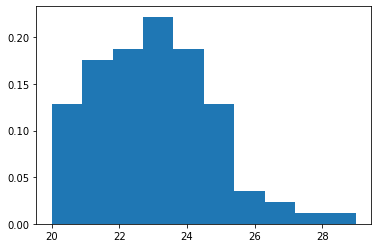

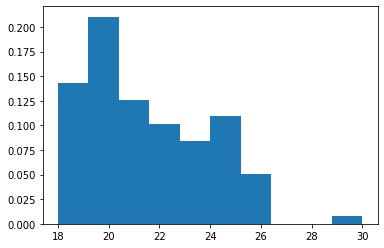

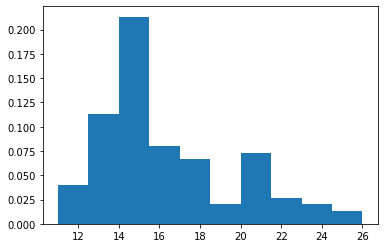

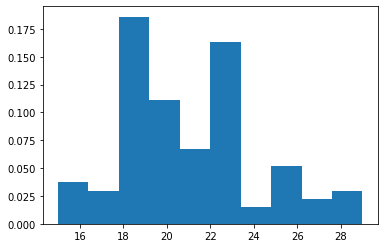

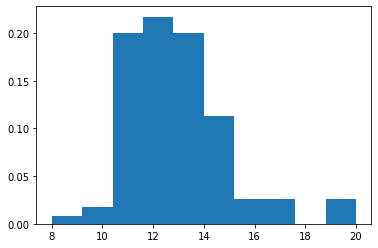

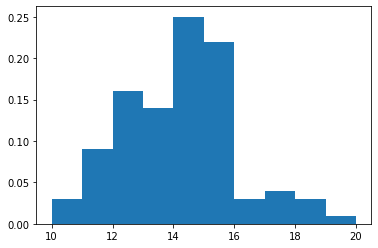

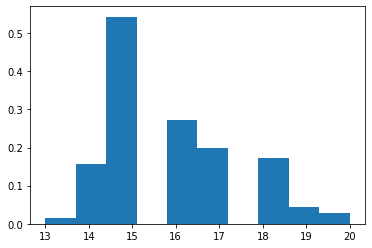

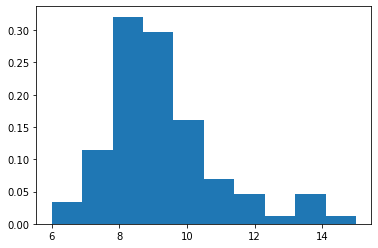

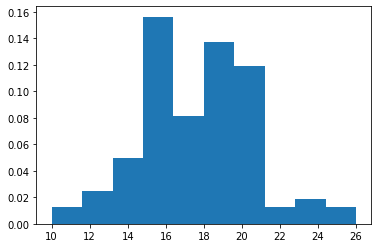

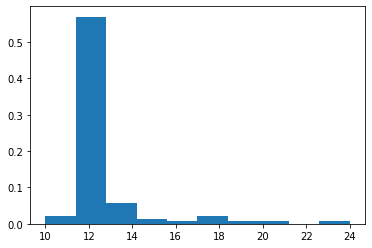

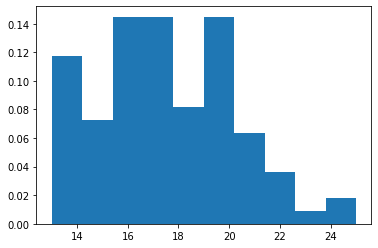

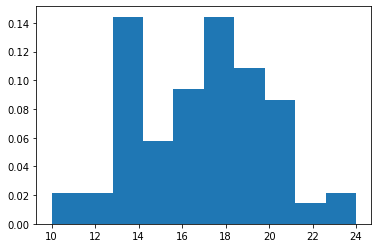

In [47]:
features[features>0.5] = 1
features[features<=0.5] = 0

count = {i:[] for i in range(class_num)}
for i in range(len(features)):
    x = features[i]
    y = y_train[i]
    c = prototypes[int(y)]
    count[int(y)].append( ((x - c)**2).sum(axis=0) )

for k in range(class_num):
    #print("min dist : ", min(count[k]))
    #print("max dist : ", max(count[k]))
    #print("mean dist : ", sum(count[k]) / len(count[k]))    
    h = sorted(np.array(count[k]))
    plt.hist(h, density=True)
    plt.show()

In [48]:
#**************************************************************************
#************************  classifier.py  *********************************
#**************************************************************************
import math

class InformationExtremeСlassifier:

    def __init__(self, etalons=None, radiuses=None):
        self.etalons   = None
        self.radiuses  = None
        if etalons is not None :
            self.etalons  = etalons
            self.class_num   = len(etalons)
            self.feature_num = len(etalons[0])
        if radiuses is not None :
            self.radiuses = radiuses

    def compute_etalons(self, X_train, y_train):
        self.class_num = len( np.unique(y_train) )
        self.feature_num = len(X_train[0])
        self.counter = { i: 0 for i in range(self.class_num)}
        self.etalons = np.zeros((self.class_num, self.feature_num))
        self.center = np.zeros(self.feature_num)
        self.n = len(X_train)
        for i in range(self.n):
            x = X_train[i]
            class_id = y_train[i]
            self.etalons[class_id] = self.etalons[class_id] + x
            self.center = self.center + x
            self.counter[class_id] = self.counter[class_id] + 1
        self.center = self.center / self.n
        for c in range(self.class_num):
            corrected_counter = max(self.counter[c], 1)
            self.etalons[c] = self.etalons[c] / corrected_counter
            self.etalons[c] = self.etalons[c] - self.center[c] 
            self.etalons[c][ self.etalons[c]  > 0 ] = 1
            self.etalons[c][ self.etalons[c] <= 0 ] = 0
        return self.etalons

    def compute_max_radiuses(self, ):
        self.max_radius = np.ones(self.class_num)*self.feature_num
        for c in range(self.class_num):
            for k in range(self.class_num):
                distance = self.get_distance(self.etalons[c], self.etalons[k])
                if c != k :
                    if distance < self.max_radius[c] :
                        self.max_radius[c] = distance
        print("self.max_radius = ", self.max_radius)

    def criterion(self, fpr, fnr, sen, spe):
        com1 = com2 = com3 = com4 = 0
        if fpr+spe > 0 :
            com1 = fpr/(fpr+spe)
            com1 = com1*math.log2(com1) if com1>0 else 0
            com2 = spe/(fpr+spe)
            com2 = com2*math.log2(com2) if com2>0 else 0
        if fnr+sen > 0 :
            com3 = fnr/(fnr+sen)
            com3 = com3*math.log2(com3) if com3>0 else 0
            com4 = sen/(sen+fnr)
            com4 = com4*math.log2(com4) if com4>0 else 0
        return 1 + 0.5*(com1+com2+com3+com4)

    def get_distance(self, b1, b2):
        return np.count_nonzero(b1!=b2)

    def compute_distance_matrix(self, X_train):
        self.n = len(X_train)
        self.counter = { i: 0 for i in range(self.class_num)}
        for i in range(self.n):
            class_id = y_train[i]
            self.counter[class_id] = self.counter[class_id] + 1

        self.dist_matrix = np.zeros((self.class_num, self.n))
        for i in range(self.n):
            x = X_train[i]
            for c in range(self.class_num):
                e = self.etalons[c]
                self.dist_matrix[c][i] = self.get_distance(x, e)

    def optimize_radiuses(self, X_train, y_train):
        self.n = len(X_train)
        self.radiuses = np.zeros(self.class_num)
        fpr = fnr = sen = spe = 0
        for c in range(self.class_num):
            с2с = np.sort(self.dist_matrix[c][y_train==c])
            с2n = np.sort(self.dist_matrix[c][y_train!=c])
            nn = min(self.counter[c], len(с2n))
            с2n = с2n[0:nn]
            E_max = 0
            for r in range(self.feature_num):
                sen = len(с2с[с2с<r])
                fpr = self.counter[c] - sen
                fnr = len(с2n[с2n<r])
                spe = self.counter[c] - fnr
                sen = sen/self.counter[c]
                fpr = fpr/self.counter[c]
                fnr = fnr/self.counter[c]
                spe = spe/self.counter[c]
                E = self.criterion(fpr, fnr, sen, spe)
                if sen > 0.5 and spe > 0.5 and r < self.max_radius[c]:
                     if E > E_max :
                         E_max = E
                         self.radiuses[c] = r
            print( "radius    ["+str(c)+"] : "+ str(self.radiuses[c]) )
            print( "criterion ["+str(c)+"] : "+ str(E_max) )
            print( "*****************************")
  
    def fit(self, X_train, y_train):
        self.n = len(X_train)
        if self.etalons is None :
            self.compute_etalons(X_train, y_train)
        self.compute_max_radiuses()
        self.compute_distance_matrix(X_train)
        self.optimize_radiuses(X_train, y_train)
        return self.etalons, self.radiuses

    def predict(self, x_test):
        result = []
        for j in range(len(x_test)):
            u = np.zeros(self.class_num)
            for c in range(self.class_num):
                e = self.etalons[c]
                dist = self.get_distance(x_test[j], e)
                u[c] = 1 - dist/self.radiuses[c]
                #u = np.exp(u)
                #u /= np.sum(u)
            result.append( np.argmax(u) )
        result = np.array(result)
        return result

In [49]:
classifier = InformationExtremeСlassifier()#etalons=prototypes)

classifier.fit(features, y_train)

self.max_radius =  [10. 10. 12. 12. 11. 12. 11. 16. 12. 20.  8.  8.]
radius    [0] : 0.0
criterion [0] : 0
*****************************
radius    [1] : 6.0
criterion [1] : 0.5576464748957983
*****************************
radius    [2] : 0.0
criterion [2] : 0
*****************************
radius    [3] : 7.0
criterion [3] : 0.5051613058105684
*****************************
radius    [4] : 7.0
criterion [4] : 0.5991083876817286
*****************************
radius    [5] : 0.0
criterion [5] : 0
*****************************
radius    [6] : 6.0
criterion [6] : 0.6794370717687792
*****************************
radius    [7] : 10.0
criterion [7] : 0.749903689450093
*****************************
radius    [8] : 0.0
criterion [8] : 0
*****************************
radius    [9] : 12.0
criterion [9] : 0.9298363645047034
*****************************
radius    [10] : 5.0
criterion [10] : 0.20399566958760018
*****************************
radius    [11] : 6.0
criterion [11] : 0.43013378049999773
**

(array([[1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.],
        [0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,

In [50]:
#**************************************************************************
#**************************** SAVE_RADIUSES *******************************
#**************************************************************************
from numpy import savetxt

# save to csv file
savetxt('gdrive/MyDrive/radiuses.csv', classifier.radiuses, delimiter=',')

In [ ]:
from sklearn.metrics import f1_score

features = []
y_test = []
for dir in os.listdir('/content/output/test'):
    for filename in os.listdir('/content/output/test'+"/"+dir) :
        if filename.endswith(".jpg") :
            img = process_image('/content/output/test'+"/"+dir+"/"+filename)
            features.append(feature_extractor.predict(img)[0])
            y_test.append( name_to_int[dir] )

features = np.array(features)
y_test = np.array(y_test)

features[features>0.5] = 1
features[features<=0.5] = 0

y_pred = classifier.predict(features)

f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='micro')